# Traitement - courbe C^infini et bruit gaussien



In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import os
from PIL import Image
from IPython.display import display

In [175]:
path = './Images/BSD500/'
img_names = []
color = ('b','g','r')
liste_histr = []
nx = 200
print(nx//20)

for folder, subfolders, filenames in os.walk(path):
    for img in filenames:
        img = cv.imread(folder+img,cv.IMREAD_COLOR)
        # Etape 1 : obtenir l'histogramme
        for i,col in enumerate(color):
            histr = cv.calcHist([img],[i],None,[256],[0,256]).squeeze()
            # interpolation pour nx points
            x = np.linspace(0,1,256, endpoint=True)
            xp = np.linspace(0,1,nx,endpoint=True)
            f = interp1d(x,histr)
            yp = f(xp)
            # normalisation
            yp = yp/np.amax(yp)
            # positif
            yp[0:10]=yp[10]
            yp[190:]= 0
            yp[yp<0]=0
            # enregistrement
            liste_histr.append(yp)

10


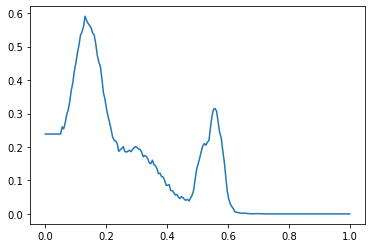

In [176]:
yp = liste_histr[15]
t = np.linspace(0,1,nx)
plt.plot(t,yp)

#### Méthode filtre Savitzky-Golay

In [161]:
y = yp.copy()
yhat155 = savgol_filter(y, 15, 5)
yhat2115 = savgol_filter(y, 21, 15)
yhat211 = savgol_filter(y, 21, 1)
yhat = savgol_filter(y, 21, 5)
yhat.shape

(200,)

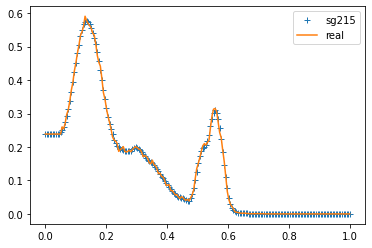

In [174]:
plt.plot(t,yhat155,'+',label='sg215')
plt.plot(t,y,label='real')
plt.legend()

In [179]:
import scipy.fftpack

x = np.linspace(0,2*np.pi,nx)

w = scipy.fftpack.rfft(y)
f = scipy.fftpack.rfftfreq(N, x[1]-x[0])
spectrum = w**2

cutoff_idx = spectrum < (spectrum.max()/1000)
w2 = w.copy()
w2[cutoff_idx] = 0

yhat2 = scipy.fftpack.irfft(w2)

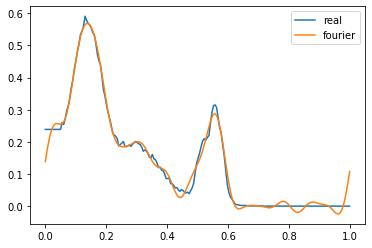

In [180]:
plt.plot(t,y,label='real')
plt.plot(t,yhat2,label='fourier')
plt.legend()

#### Convolution

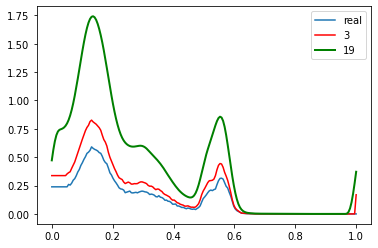

In [165]:
from numpy.fft import fft, ifft, fftshift
def smooth(y, box_pts):
    x_pts = np.linspace(0.0000001,0.9999999,box_pts)
    box = np.exp(-1/x_pts)*np.exp(-1/(1-x_pts))
    box = box/np.linalg.norm(box)
    nx = y.shape[0]
    box = np.pad(box,(nx//2 - box_pts//2,nx//2 - box_pts//2), 'constant')
    # Convolution
    fr = fft(box)
    fr2 = fft(y)
    y_smooth = fftshift(np.real(ifft(fr*fr2)))
    return y_smooth


plt.plot(t, y, label='real')
plt.plot(t, smooth(y,4), 'r-',label ='3')
plt.plot(t, smooth(y,20), 'g-', lw=2,label='19')
plt.legend()

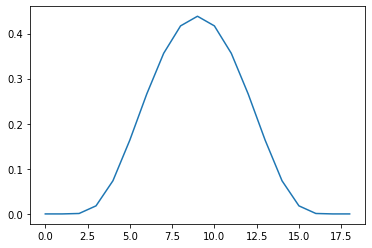

In [166]:
x_pts = np.linspace(0.00001,0.99999,19)
box = np.exp(-1/x_pts)*np.exp(-1/(1-x_pts))
box = box/np.linalg.norm(box)
plt.plot(box)

### COMPARAISONS

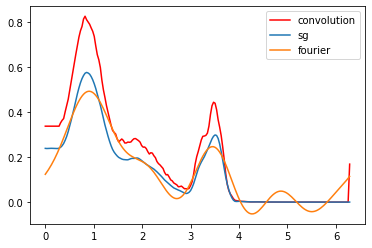

In [167]:
plt.plot(x, smooth(y,4), 'r-', label= "convolution")
plt.plot(x,yhat, label = "sg")
plt.plot(x,yhat2, label = "fourier")
plt.legend()